In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
# ---------------------------------------------------------
# 1. VERİ YÜKLEME VE ÖN İŞLEME
# ---------------------------------------------------------
print("1. Veri yükleniyor ve hazırlanıyor...")

data_path = "../data/secondary_data.csv"
df = pd.read_csv(data_path, sep=";")

target_col = "class"
X = df.drop(columns=[target_col])
y = df[target_col].map({'p': 1, 'e': 0}) 

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print(f"Toplam Özellik Sayısı: {X.shape[1]} (20 feature kuralına uygun)")



1. Veri yükleniyor ve hazırlanıyor...
Toplam Özellik Sayısı: 20 (20 feature kuralına uygun)


In [3]:
# Pipeline (Feature Dropping YOK, Imputation VAR)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
# ---------------------------------------------------------
# 2. BASELINE (DUMMY) MODEL
# ---------------------------------------------------------
print("\n2. Baseline (Dummy) Model eğitiliyor...")
dummy_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy="most_frequent"))
])
dummy_pipeline.fit(X_train, y_train)
dummy_acc = accuracy_score(y_test, dummy_pipeline.predict(X_test))
print(f"-> Baseline Accuracy: {dummy_acc:.4f}")



2. Baseline (Dummy) Model eğitiliyor...
-> Baseline Accuracy: 0.5549


In [6]:
# ---------------------------------------------------------
# 3. HYPERPARAMETER TUNING (RANDOM FOREST)
# ---------------------------------------------------------
print("\n3. Random Forest Tuning başlıyor... (4 Parametre deneniyor)")

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# GÜNCELLENMİŞ PARAMETRE LİSTESİ (4 TANE)
param_grid = {
    'classifier__n_estimators': [50, 100],       # Ağaç sayısı
    'classifier__max_depth': [10, 20, None],     # Maksimum derinlik
    'classifier__min_samples_split': [2, 5],     # Bölünme için min örnek
    'classifier__min_samples_leaf': [1, 2]       # Yaprak için min örnek (EKLENDİ)
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"En İyi Parametreler: {best_params}")



3. Random Forest Tuning başlıyor... (4 Parametre deneniyor)
Fitting 3 folds for each of 24 candidates, totalling 72 fits
En İyi Parametreler: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}



4. Grafikler oluşturuluyor...
Tüm grafikler kaydedildi.


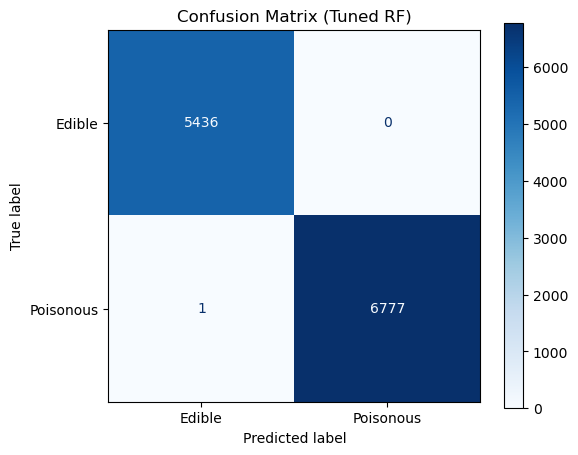

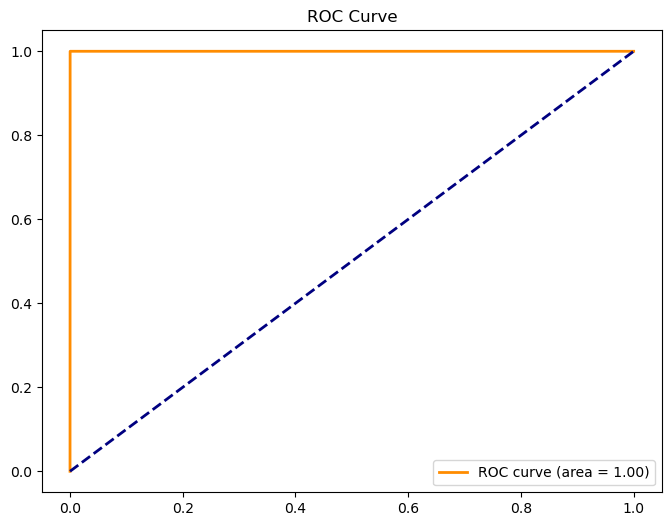

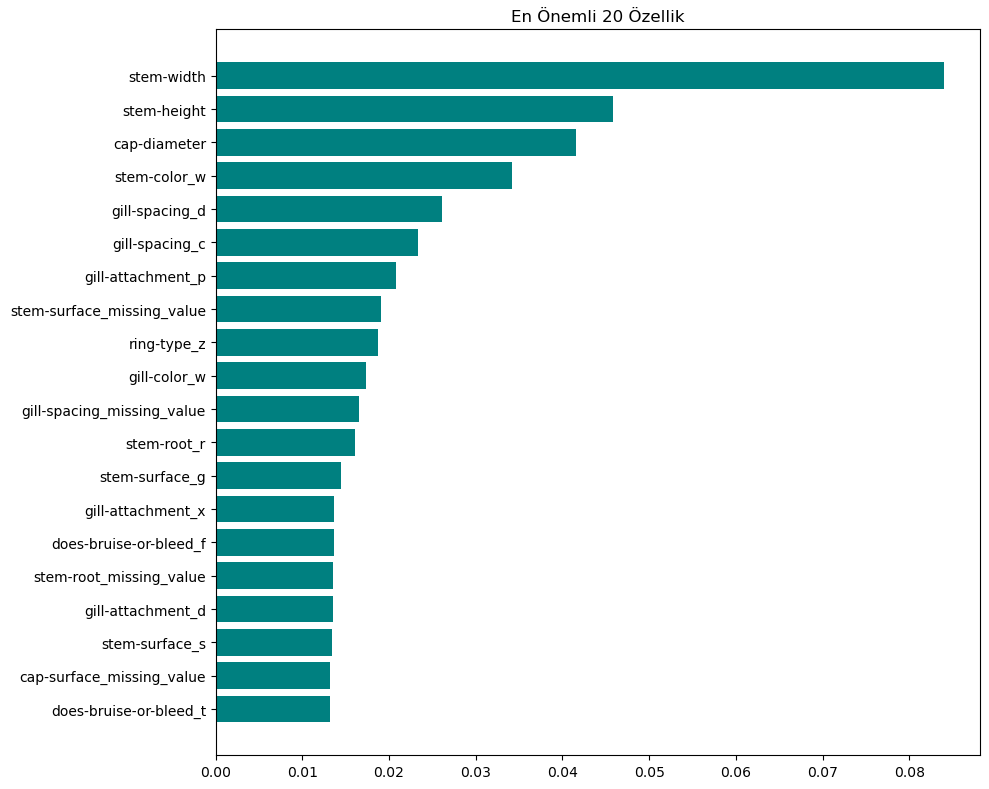

In [7]:
# ---------------------------------------------------------
# 4. SONUÇLAR VE GRAFİKLER
# ---------------------------------------------------------
print("\n4. Grafikler oluşturuluyor...")

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Grafik 1: Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', display_labels=['Edible', 'Poisonous'])
ax.set_title("Confusion Matrix (Tuned RF)")
plt.savefig('confusion_matrix_final.png')

# Grafik 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.savefig('roc_curve_final.png')

# Grafik 3: Feature Importance
importances = best_model.named_steps['classifier'].feature_importances_
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.r_[numeric_cols, cat_feature_names]
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], color='teal', align="center")
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
plt.title("En Önemli 20 Özellik")
plt.tight_layout()
plt.savefig('feature_importance_final.png')

print("Tüm grafikler kaydedildi.")


In [8]:
# ---------------------------------------------------------
# 5. KARŞILAŞTIRMA (LOGISTIC REGRESSION)
# ---------------------------------------------------------
print("\n5. Logistic Regression eğitiliyor...")
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
lr_pipeline.fit(X_train, y_train)
lr_acc = accuracy_score(y_test, lr_pipeline.predict(X_test))

print("-" * 40)
print("FINAL MODEL KARŞILAŞTIRMA TABLOSU")
print("-" * 40)
print(f"1. Baseline (Dummy) Accuracy   : {dummy_acc:.4f}")
print(f"2. Logistic Regression Accuracy: {lr_acc:.4f}")
print(f"3. Random Forest Accuracy      : {acc:.4f}")
print("-" * 40)




5. Logistic Regression eğitiliyor...
----------------------------------------
FINAL MODEL KARŞILAŞTIRMA TABLOSU
----------------------------------------
1. Baseline (Dummy) Accuracy   : 0.5549
2. Logistic Regression Accuracy: 0.8683
3. Random Forest Accuracy      : 0.9999
----------------------------------------
